## Github Reviewer Recommendation using Graph Neural Network (GraphSAGE)

In [1224]:
#!pip install chars2vec

In [1225]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from datetime import datetime
from collections import Counter
import time
import requests
import pickle
import sys
import chars2vec
from tqdm import tqdm_notebook as tqdm

import stellargraph as sg
from stellargraph import StellarGraph
from sklearn.preprocessing import OrdinalEncoder
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph import globalvar
from stellargraph import datasets
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.metrics.pairwise import cosine_similarity
import heapq

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from IPython.display import display, HTML
%matplotlib inline

### Building edges between PR and Reviewer nodes

In [1226]:
def connect_reviewer_pr_networks(graph, data, filepath_data):
    pr_id_list = filepath_data['pr_id'].unique()
    edge_list_sample = []
    
    for pr_id in tqdm(pr_id_list):
        if graph.has_node(pr_id): 
            pr_owner_set, reviewer_set = get_pr_reviewers(pr_id, data)
            for commenter in reviewer_set:
                num_comments = get_num_comments(pr_id, commenter, data)
                graph.add_edge(pr_id, commenter, weight=num_comments)
                
                for pr_id in pr_id_list:
                    if graph.has_node(pr_id) and graph.has_node(commenter):
                        if [pr_id, commenter] not in edge_list_sample:
                            edge_list_sample.append([pr_id, commenter])
            
    return graph, edge_list_sample

def get_pr_reviewers(pr_id, data):
    pr_df = data.loc[data.github_pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def get_num_comments(pr_id, commenter, data):
    comments = data[(data['commenter_id']==commenter) & \
        ((data['github_pr_id']==pr_id))]
    num_comments = len(comments)
    return num_comments  

### Building graph between PRs based upon content similarity

In [1227]:
def build_pr_graph(graph, data, title_data):
    for pr_source in tqdm(data.index):
            similarities = {}
            if not graph.has_node(pr_source):
                pr_info = pr_feature_info(pr_source, data)
                graph.add_node(pr_source, **pr_info)
                
            for pr_target in data.index:
                if pr_source != pr_target:
                    if not graph.has_node(pr_target):
                        pr_info = pr_feature_info(pr_target, data)
                        graph.add_node(pr_target, **pr_info)
                    
                    pr_source_feature = data.loc[pr_source,:][3].reshape(1, -1)
                    pr_source_title_feature = list(title_data[title_data.pr_id == pr_source]['c2v_title'])[0].reshape(1, -1)
                    pr_target_feature = data.loc[pr_target,:][3].reshape(1, -1)
                    pr_target_title_feature = list(title_data[title_data.pr_id == pr_target]['c2v_title'])[0].reshape(1, -1)
                    similarity_path = generate_cosine_similarity(pr_source_feature, pr_target_feature) 
                    similarity_title = generate_cosine_similarity(pr_source_feature, pr_target_feature) 
                    similarities[pr_target] =  similarity_path[0][0] + similarity_title[0][0]
    
            #similarities = {k: v for k, v in sorted(similarities.items(), key=lambda item: item[1], reverse=True)}
            k = 20
            pr_target_sorted = heapq.nlargest(k, similarities,  key = similarities.get)
            
            for pr_target in pr_target_sorted:
                if not graph.has_edge(pr_source, pr_target):
                    weight = similarities[pr_target]
                    graph.add_edge(pr_source, pr_target, weight=weight)
                    

    return graph

def pr_feature_info(target, data):
    info_cols = ['average_additions', 'average_changes', 'average_deletions', 'filepath_count']
    info_dict = data.loc[(data.pr_id == target), info_cols].iloc[0].to_dict()
    info_dict = create_features(info_dict)
    return info_dict
    
def generate_cosine_similarity(pr_source, pr_target):
    return cosine_similarity(pr_source, pr_target)
    

### Building comment network graph between Reviewer nodes

In [1228]:
def build_comment_graph(graph, data):
    pr_id_list = data['pr_id'].unique()
    for pr_id in tqdm(pr_id_list):
        pr_owner_set, reviewer_set = get_node_ids(pr_id, data)

        for pr_owner_id in pr_owner_set:
            if not graph.has_node(pr_owner_id):
                user_info = node_info(pr_owner_id, data)
                graph.add_node(pr_owner_id, **user_info)

            for reviewer_id in reviewer_set:
                if not graph.has_node(reviewer_id):
                    user_info = node_info(reviewer_id, data)
                    graph.add_node(reviewer_id, **user_info)
                
                if not graph.has_edge(pr_owner_id, reviewer_id):
                    weight = get_edge_weight(pr_owner_id, reviewer_id, data)
                    graph.add_edge(pr_owner_id, reviewer_id, weight=weight)

    return graph

def get_edge_weight(pr_owner_id, reviewer_id, data):
    df = data[(data['commenter_id']==reviewer_id) & \
        ((data['head_commit_author_id']==pr_owner_id) | (data['head_commit_committer_id']==pr_owner_id))]
    
    comment_times = df['comment_created_at'].map(convert_to_tic)
    df['weight'] = comment_times
    df = df.sort_values(by='weight')

    decay = 0.8
    counts = Counter()
    for index, row in df.iterrows():
        row['weight'] *= decay**counts[(row['pr_id'], row['commenter_id'])]
        counts[(row['pr_id'], row['commenter_id'])] += 1

    weight = df['weight'].sum()
    return weight

def get_node_ids(pr_id, data):
    pr_df = data.loc[data.pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def create_features(info_dict):
    features = {}
    features["features"] = list(info_dict.values())
    return features
    
def node_info(target, data):
    info_cols = ['commenter_username_enc', 'commenter_follower_count',
                        'commenter_total_github_commit_count', 'commenter_base_repo_commit_count']
    info_dict = data.loc[(data.commenter_id == target), info_cols].iloc[0].to_dict()
    info_dict = create_features(info_dict)
    return info_dict

def convert_to_tic(s):
    #Jan, 1, 2014
    start_time = time.mktime(datetime(2014, 1, 1).timetuple())
    #Jan, 1, 2019
    end_time = time.mktime(datetime(2019, 1, 1).timetuple())
    time_delta = end_time-start_time
    return float(time.mktime(pd.to_datetime(s).timetuple()) - start_time) / time_delta

### Data Preprocessing

In [1229]:
def prepare_inputs(data):
    oe = OrdinalEncoder()
    oe.fit(data)
    data_enc = oe.transform(data)
    return data_enc

In [1230]:
# chars2vec character-based language model to handle text features
c2v = chars2vec.load_model('eng_100')

In [1231]:
file_Path_data = pd.read_csv('filepath.csv')

In [1232]:
filepath_df = file_Path_data

In [1233]:
pr_filepath_list = filepath_df.loc[:, 'filename'].values


In [1234]:
# converting pathpath into a 100 dimention numeric vector 
filepath_vector = []
for filepath in tqdm(pr_filepath_list):
    components = filepath.split('/')
    vec = c2v.vectorize_words(components)
    filepath_vector.append(np.mean(vec, axis=0))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [1235]:
file_Path_data['c2v_filepath'] = filepath_vector

In [1236]:
file_Path_data['c2v_filepath'].shape

(79659,)

In [1237]:
filepath_summary_df = pd.concat([file_Path_data.groupby('pr_id')['additions', 'changes', 'deletions'].mean(), 
                                 file_Path_data.groupby('pr_id')['c2v_filepath'].apply(lambda x: np.mean(x, axis=0)),
                                 file_Path_data.groupby('pr_id')['filename'].count()], axis=1)
filepath_summary_df.columns = ['average_additions', 'average_changes', 'average_deletions', 'average_c2v_filepath', 'filepath_count']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [1238]:
filepath_summary_df['pr_id'] = filepath_summary_df.index

In [1239]:
filepath_summary_df = filepath_summary_df[:600]

In [1240]:
title_data = pd.read_csv('pull_req_titles.csv')
title_list = title_data.loc[:, 'title'].values

In [1241]:
title_vec = []
for filepath in tqdm(title_list):
    components = filepath.split()
    vec = c2v.vectorize_words(components)
    title_vec.append(np.mean(vec, axis=0))
title_data['c2v_title'] = title_vec

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1242]:
data = pd.read_csv('kubernetes.csv')
d = prepare_inputs(data[['commenter_username']])
data['commenter_username_enc'] = d

### Datasets

In [1243]:
# comment data 
data

,pr_id,github_pr_id,commenter_id,commenter_username,commenter_follower_count,commenter_total_github_commit_count,commenter_base_repo_commit_count,head_commit_author_id,head_commit_author_username,head_commit_committer_id,...,head_repo_owner_id,head_repo_owner_username,head_commit_id,base_commit_id,pullreq_id,comment_created_at,comment_position,comment_id,comment_body,commenter_username_enc
0,16143045,28120,7684572,vefimova,3,407,7,7684572,vefimova,7684572,...,7684572,vefimova,488416504,487143381,28120,2016-07-04 10:35:17 UTC,19,69439208,"Yes, they're all in list. But still it would b...",1146.0
1,16143045,28120,7684572,vefimova,3,407,7,7684572,vefimova,7684572,...,7684572,vefimova,488416504,487143381,28120,2016-07-06 15:10:43 UTC,4,69749453,the same answer here :),1146.0
2,16143045,28120,7684572,vefimova,3,407,7,7684572,vefimova,7684572,...,7684572,vefimova,488416504,487143381,28120,2016-07-06 15:03:49 UTC,24,69748071,This check is called in case of failure of CRE...,1146.0
3,16143045,28120,7684572,vefimova,3,407,7,7684572,vefimova,7684572,...,7684572,vefimova,488416504,487143381,28120,2016-07-04 10:36:07 UTC,24,69439304,"thx, will fix",1146.0
4,16143045,28120,7684572,vefimova,3,407,7,7684572,vefimova,7684572,...,7684572,vefimova,488416504,487143381,28120,2016-07-04 10:36:02 UTC,31,69439297,"thx, will fix",1146.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132840,25176148,46966,4659404,deads2k,95,15279,786,2950878,ilackarms,2950878,...,2950878,ilackarms,707726103,707605581,46966,2017-06-06 15:14:36 UTC,4,120390193,this should cause you to fail a verify script.,357.0
132841,25176148,46966,4659404,deads2k,95,15279,786,2950878,ilackarms,2950878,...,2950878,ilackarms,707726103,707605581,46966,2017-06-06 15:14:50 UTC,4,120390258,It's why you need a generic feature flag.,357.0
132842,24395322,45666,3204869,kargakis,71,11252,342,2950878,ilackarms,2950878,...,2950878,ilackarms,689275934,690621974,45666,2017-06-03 01:08:09 UTC,68,119975004,lowercase the start of the godoc,661.0
132843,24395322,45666,3204869,kargakis,71,11252,342,2950878,ilackarms,2950878,...,2950878,ilackarms,689275934,690621974,45666,2017-06-03 01:07:48 UTC,24,119974994,Separate stdlib imports from k8s imports,661.0


In [1244]:
# filepath data
filepath_summary_df

,average_additions,average_changes,average_deletions,average_c2v_filepath,filepath_count,pr_id
pr_id,,,,,,
3810,22.647059,36.529412,13.882353,"[-0.42830998, 0.11934379, 0.0045948424, 0.1383...",17,3810
5093,76.760000,78.360000,1.600000,"[-0.29726705, 0.1870893, -0.0065093637, 0.0160...",25,5093
5446,47.125000,50.375000,3.250000,"[-0.35974368, 0.1993072, -0.0074786684, 0.1189...",8,5446
5763,17.333333,24.633333,7.300000,"[-0.21188231, 0.06627194, -0.078078255, -0.029...",30,5763
5830,8.000000,9.000000,1.000000,"[-0.040795784, 0.11978642, 0.033581033, 0.3804...",1,5830
...,...,...,...,...,...,...
14550,26.333333,46.666667,20.333333,"[-0.4248884, 0.22886688, 0.060796153, 0.240098...",3,14550
14551,37.700000,39.400000,1.700000,"[-0.36146015, 0.20489497, -0.058182724, 0.0244...",10,14551
14553,14.000000,21.000000,7.000000,"[-0.499357, 0.21513298, 0.08360959, 0.04649373...",2,14553


In [1245]:
# PR title data
title_data

,pr_id,state,title,body,created_at,updated_at,closed_at,merged_at,c2v_title
0,32769,closed,clientgen: allow to pass custom apiPath when g...,This PR allow to pass the `--clientset-api-pat...,2016-09-15T10:11:55Z,2016-10-17T11:52:04Z,2016-10-17T11:52:04Z,2016-10-17T11:52:04Z,"[-0.32718894, 0.10044608, -0.049924213, -0.024..."
1,32771,closed,MinReadySeconds / AvailableReplicas for Replic...,This PR adds minReadySeconds and availableRepl...,2016-09-15T10:13:55Z,2016-09-28T13:41:11Z,2016-09-28T13:17:54Z,2016-09-28T13:17:54Z,"[-0.36500558, 0.2037448, 0.055058192, 0.308119..."
2,32774,closed,support building with bazel,```\n$ bazel version\nBuild label: 0.3.1\nBui...,2016-09-15T10:37:33Z,2017-01-03T08:13:36Z,2016-10-22T01:15:30Z,2016-10-22T01:15:30Z,"[-0.044354472, 0.069892265, -0.103370234, 0.25..."
3,32776,closed,[Controller Manager] Fix endpoint controller h...,<!-- Thanks for sending a pull request! Here...,2016-09-15T11:30:16Z,2016-09-20T00:52:15Z,2016-09-18T03:01:41Z,2016-09-18T03:01:41Z,"[-0.30618578, 0.17392097, 0.10421513, 0.034414..."
4,32778,closed,recommendations for writing controllers,There have been questions about how to write c...,2016-09-15T11:40:16Z,2017-02-01T17:25:19Z,2016-10-18T14:20:46Z,2016-10-18T14:20:46Z,"[-0.6259688, 0.12793466, 0.048771158, 0.030597..."
...,...,...,...,...,...,...,...,...,...
11468,32751,closed,Specific error message on failed rolling updat...,Fix #32706\n\n`kubernetes-e2e-gke-1.4-1.3-kube...,2016-09-15T00:50:01Z,2016-09-17T08:07:27Z,2016-09-16T04:41:57Z,2016-09-16T04:41:56Z,"[-0.22287665, 0.17678161, 0.012020456, 0.03112..."
11469,32752,closed,Allow a selector when retrieving logs,#19873\n\ninitial commit to see if I am headed...,2016-09-15T01:26:00Z,2016-12-09T00:25:54Z,2016-12-09T00:25:54Z,2016-12-09T00:25:54Z,"[-0.2879012, 0.17807911, 0.02204235, -0.074969..."
11470,32754,closed,"Add missing test owners, reassign swagiaal",<!-- Reviewable:start -->\n\nThis change is [<...,2016-09-15T01:33:52Z,2019-11-06T15:41:20Z,2016-09-19T19:51:28Z,NaN,"[-0.08237859, 0.13871324, -0.043578517, 0.1916..."
11471,32760,closed,simplify logic of containerAndPodFromLabels func,Removing the else primitive to make the code s...,2016-09-15T05:22:57Z,2016-09-15T23:30:19Z,2016-09-15T23:30:19Z,NaN,"[-0.4534576, 0.34677345, -0.048078977, 0.17180..."


### Graph Construction (networkx)

In [1246]:
user_graph = nx.Graph()

In [1247]:
title_data = title_data.sort_values('pr_id')

In [1248]:
user_graph = build_comment_graph(user_graph, data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1249]:
user_graph = build_pr_graph(user_graph, filepath_summary_df, title_data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1250]:
user_graph, edge_list_sample = connect_reviewer_pr_networks(user_graph, data, filepath_summary_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


### Building Training/Testing Graphs

In [1251]:
edge_list_positive = []
edge_list_negative = []

for edge in (edge_list_sample):
    if int(user_graph.has_edge(*edge)) == 0:
        edge_list_negative.append([edge, int(user_graph.has_edge(*edge))])
    else:
        edge_list_positive.append([edge, int(user_graph.has_edge(*edge))])

In [1252]:
len(edge_list_positive)

698

In [1253]:
len(user_graph.edges())

16454

In [1254]:
def edge_splitter(user_graph, edge_list_positive, edge_list_negative, p = 10):
    samples = int(len(edge_list_positive)/p)
    print(len(user_graph.edges()), samples)
    edge_ids_test = []
    edge_labels_test = []
    for i in range(samples):
        if edge_list_positive[i][0] not in edge_ids_test:
            if user_graph.has_edge(*edge_list_positive[i][0]) == True:
                edge_ids_test.append(edge_list_positive[i][0])
                edge_labels_test.append(1)
                user_graph.remove_edge(*edge_list_positive[i][0])
            
    
    num_positive = len(edge_ids_test)
    for i in range(num_positive):
        edge_ids_test.append(edge_list_negative[i][0])
        edge_labels_test.append(0)        
        
    edge_list_positive = edge_list_positive[num_positive:]
    edge_list_negative = edge_list_negative[num_positive:]
    
    print(len(user_graph.edges()),len(edge_list_positive), len(edge_list_negative))
    
    G_test = StellarGraph.from_networkx(user_graph, node_features = 'features')
    
    samples = int(len(edge_list_positive)/p)
    
    edge_ids_train = []
    edge_labels_train = []
    for i in range(samples):
        if edge_list_positive[i][0] not in edge_ids_train:
            if user_graph.has_edge(*edge_list_positive[i][0]) == True:
                edge_ids_train.append(edge_list_positive[i][0])
                edge_labels_train.append(1)
                user_graph.remove_edge(*edge_list_positive[i][0])
            
    
    num_positive = len(edge_labels_train)
    for i in range(num_positive):
        edge_ids_train.append(edge_list_negative[i][0])
        edge_labels_train.append(0)        
        
    edge_list_positive = edge_list_positive[samples:]
    edge_list_positive = edge_list_positive[samples:]
    print(len(user_graph.edges()),len(edge_list_positive), len(edge_list_negative))
    G_train = StellarGraph.from_networkx(user_graph, node_features = 'features')
    
    return G_test, edge_ids_test, edge_labels_test, G_train, edge_ids_train, edge_labels_train
    

In [1255]:
print(len(user_graph.edges()))

16454


In [1256]:
user_graph_copy = user_graph
edge_list_positive_copy = edge_list_positive
edge_list_negative_copy = edge_list_negative
G_test, edge_ids_test, edge_labels_test, G_train, edge_ids_train, edge_labels_train = edge_splitter(user_graph_copy, edge_list_positive_copy, edge_list_negative_copy)


16454 69
16385 629 77233
16323 505 77233


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: found the following nodes (of type 'default') without features, using 4-dimensional zero vector: 34132424, 708297, 896759, 22578, 11941927, 200679, 6008391
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: found the following nodes (of type 'default') without features, using 4-dimensional zero vector: 34132424, 708297, 896759, 22578, 11941927, 200679, 6008391


In [1257]:
len(G_train.edges())

16323

In [1258]:
len(G_test.edges())

16385

In [1259]:
len(edge_ids_test)

138

In [1260]:
len(edge_labels_train)

124

In [1261]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 1796, Edges: 16323

 Node types:
  default: [1796]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [16323]
        Weights: range=[0, 507.954], mean=3.29046, std=8.55109
        Features: none


In [1262]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 1796, Edges: 16385

 Node types:
  default: [1796]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [16385]
        Weights: range=[0, 507.954], mean=3.29382, std=8.54703
        Features: none


### Graph Neural Network Model 

In [1263]:
batch_size = 20
epochs = 29

In [1264]:
num_samples = [20, 10]

In [1265]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [1266]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [1267]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [1268]:
x_inp, x_out = graphsage.in_out_tensors()

In [1269]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [1270]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [1271]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=['acc',f1_m,precision_m, recall_m],
)

### Results

Evaluate the initial (untrained) model on the train and test set:

In [1272]:
loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(train_flow)
loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names,(loss_train, accuracy_train)):
    print("\t{}: {:0.4f}".format(name, val))
    
print('\tF1 score: %0.4f' % f1_score_train)
print('\tPrecision: %0.4f' % precision_train)
print('\tRecall: %0.4f' % recall_train)


print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, (loss_test, accuracy_test)):
    print("\t{}: {:0.4f}".format(name, val))

print('\tF1 score: %0.4f' % f1_score_test)
print('\tPrecision: %0.4f' % precision_test)
print('\tRecall: %0.4f' % recall_test)

7/7 [==============================] - 0s 20ms/step - loss: 1.1320 - acc: 0.4348 - f1_m: 0.2876 - precision_m: 0.5357 - recall_m: 0.1976

Train Set Metrics of the initial (untrained) model:
	loss: 2.0847
	acc: 0.2016
	F1 score: 0.0451
	Precision: 0.0561
	Recall: 0.0379

Test Set Metrics of the initial (untrained) model:
	loss: 1.1320
	acc: 0.4348
	F1 score: 0.2876
	Precision: 0.5357
	Recall: 0.1976


Train the model:

In [1273]:
history = model.fit(train_flow, epochs=epochs, validation_data = test_flow, verbose = 2)

Epoch 1/29
7/7 - 0s - loss: 2.3708 - acc: 0.3629 - f1_m: 0.1904 - precision_m: 0.2624 - recall_m: 0.1644 - val_loss: 0.9171 - val_acc: 0.4783 - val_f1_m: 0.2911 - val_precision_m: 0.4571 - val_recall_m: 0.2159
Epoch 2/29
7/7 - 0s - loss: 1.8298 - acc: 0.3790 - f1_m: 0.2300 - precision_m: 0.2905 - recall_m: 0.2002 - val_loss: 0.8051 - val_acc: 0.5290 - val_f1_m: 0.3927 - val_precision_m: 0.5000 - val_recall_m: 0.3278
Epoch 3/29
7/7 - 0s - loss: 1.5429 - acc: 0.3548 - f1_m: 0.2590 - precision_m: 0.3474 - recall_m: 0.2195 - val_loss: 0.7749 - val_acc: 0.5290 - val_f1_m: 0.4280 - val_precision_m: 0.4935 - val_recall_m: 0.3865
Epoch 4/29
7/7 - 0s - loss: 1.5770 - acc: 0.3710 - f1_m: 0.3102 - precision_m: 0.3390 - recall_m: 0.3248 - val_loss: 0.8359 - val_acc: 0.4420 - val_f1_m: 0.3927 - val_precision_m: 0.4714 - val_recall_m: 0.3405
Epoch 5/29
7/7 - 0s - loss: 1.2263 - acc: 0.3548 - f1_m: 0.2881 - precision_m: 0.3175 - recall_m: 0.2774 - val_loss: 0.8208 - val_acc: 0.5362 - val_f1_m: 0.4752

Plot the training history:

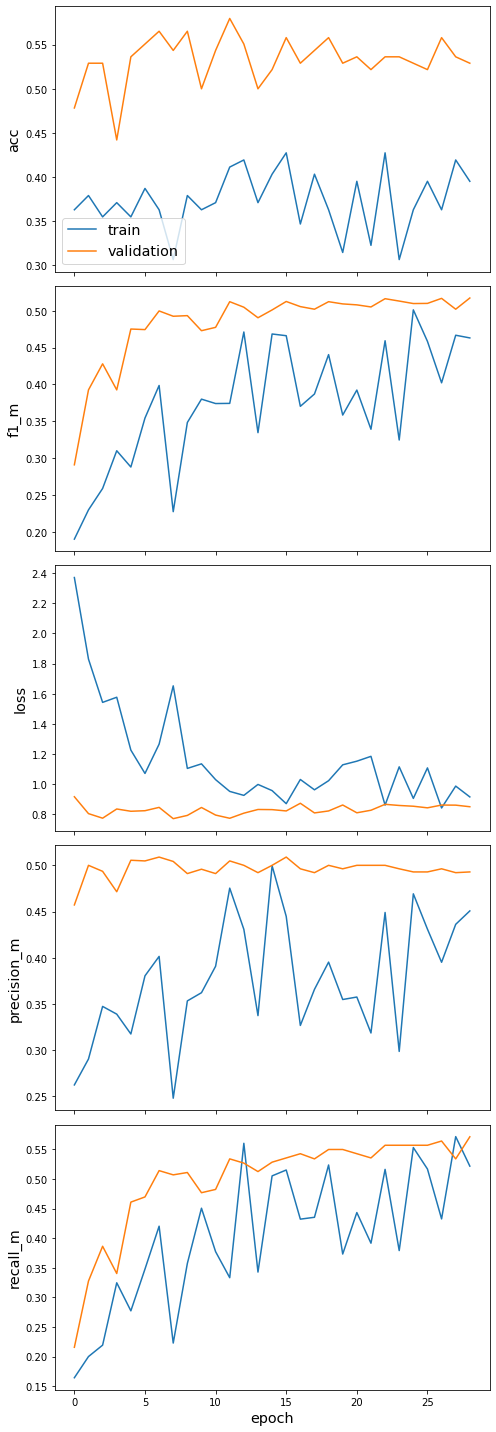

In [1274]:
sg.utils.plot_history(history)

Evaluate the trained model on test PR-Reviewer links:

In [1275]:
loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(train_flow)
loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names,(loss_train, accuracy_train)):
    print("\t{}: {:0.4f}".format(name, val))
    
print('\tF1 score: %0.4f' % f1_score_train)
print('\tPrecision: %0.4f' % precision_train)
print('\tRecall: %0.4f' % recall_train)


print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, (loss_test, accuracy_test)):
    print("\t{}: {:0.4f}".format(name, val))

print('\tF1 score: %0.4f' % f1_score_test)
print('\tPrecision: %0.4f' % precision_test)
print('\tRecall: %0.4f' % recall_test)

7/7 [==============================] - 0s 21ms/step - loss: 0.8991 - acc: 0.5000 - f1_m: 0.5172 - precision_m: 0.4929 - recall_m: 0.5714

Train Set Metrics of the initial (untrained) model:
	loss: 0.9964
	acc: 0.4435
	F1 score: 0.5237
	Precision: 0.4099
	Recall: 0.7405

Test Set Metrics of the initial (untrained) model:
	loss: 0.8991
	acc: 0.5000
	F1 score: 0.5172
	Precision: 0.4929
	Recall: 0.5714
